In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(1)

## Loading the datasets, i.e loading frames for few actions

In [2]:
#loading and prepping data
#initially only one action
dframe = pd.read_csv('./csv_data/action_1.csv')
dframe2 = pd.read_csv('./csv_data/action_2.csv')
dframe3 = pd.read_csv('./csv_data/action_3.csv')
dframe4 = pd.read_csv('./csv_data/action_4.csv')
dframe5 = pd.read_csv('./csv_data/action_5.csv')
dframe6 = pd.read_csv('./csv_data/action_6.csv')
dframe7 = pd.read_csv('./csv_data/action_7.csv')

#to look at data
dframe.iloc[0:5, :]

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,label,id,video_id
0,-0.382997,-0.419442,3.449989,-0.366909,-0.092619,3.443680,-0.353380,0.229542,3.427116,-0.391862,...,3.636719,-0.435790,-0.536338,3.280097,-0.364369,-0.491436,3.269750,1,72057594037944340,0
1,-0.383146,-0.419292,3.450006,-0.367569,-0.092003,3.443895,-0.353885,0.230300,3.427162,-0.391820,...,3.633053,-0.436031,-0.536649,3.281972,-0.358806,-0.471054,3.269975,1,72057594037944340,0
2,-0.385776,-0.421191,3.449611,-0.369506,-0.092775,3.443796,-0.354571,0.230189,3.426965,-0.403822,...,3.632370,-0.436489,-0.536484,3.286322,-0.358079,-0.470344,3.270202,1,72057594037944340,0
3,-0.385807,-0.421205,3.449582,-0.369576,-0.092714,3.443878,-0.354524,0.230369,3.427140,-0.403580,...,3.499778,-0.441701,-0.533234,3.278971,-0.360298,-0.476572,3.268953,1,72057594037944340,0
4,-0.357840,-0.420304,3.438846,-0.364956,-0.092426,3.442334,-0.354907,0.230391,3.427352,-0.405945,...,3.400878,-0.430001,-0.536492,3.278641,-0.358697,-0.471415,3.270685,1,72057594037944340,0


## Some utility functions to split the datasets and loading the datasets in batch

In [3]:
#making test and train split
#the recentering has been done so that the pelvic joint is always at the origin
#labels are to be zero indexed
def train_test_split(dframe_list):
    train_split = np.empty(0, dtype=object)
    test_split = np.empty(0, dtype=object)
    for dframe in dframe_list:
        label = dframe.iloc[0,75]-1
#         print(label)
        num_samples = len(dframe.iloc[:,:])
        video_ids = np.unique(dframe.iloc[:,-1].values)
        train_video_ids = video_ids[:-15]
        test_video_ids = video_ids[-15:]
        train_split1 = np.empty(len(train_video_ids), dtype=object)
        test_split1 = np.empty(len(test_video_ids), dtype=object)
        for idx,i in enumerate(train_video_ids):
            train_split1[idx] = dframe.loc[dframe['video_id'] == i].values[:,0:75]
            for fidx, f in enumerate(train_split1[idx]):
                f = np.reshape(f, (25,3))
                f = f-f[0,:]
                f = np.reshape(f, (1,75))
                train_split1[idx][fidx] = f
#             mean_vec = np.mean(train_split1[idx], axis=0)
#             std_vec = np.std(train_split1[idx], axis=0)
            train_split1[idx] = (train_split1[idx], label)

        for idx,i in enumerate(test_video_ids):
            test_split1[idx] = dframe.loc[dframe['video_id'] == i].values[:,0:75]
            for fidx, f in enumerate(test_split1[idx]):
                f = np.reshape(f, (25,3))
                f = f-f[0,:]
                f = np.reshape(f, (1,75))
                test_split1[idx][fidx] = f
#             mean_vec = np.mean(test_split1[idx], axis=0)
#             std_vec = np.std(test_split1[idx], axis=0)
            test_split1[idx] = (test_split1[idx], label)
        train_split = np.concatenate((train_split, train_split1))
        test_split = np.concatenate((test_split, test_split1))
    return train_split, test_split

train_split, test_split = train_test_split([dframe, dframe2, dframe3, dframe4, dframe5, dframe6, dframe7])

# #looking at split
train_split[0:3]

array([ (array([[ 0.       ,  0.       ,  0.       , ...,  0.0186279, -0.0719937,
        -0.180239 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.0243399, -0.0517625,
        -0.180031 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.0276977, -0.0491529,
        -0.179409 ],
       ..., 
       [ 0.       ,  0.       ,  0.       , ..., -0.0563203, -0.0113986,
        -0.174284 ],
       [ 0.       ,  0.       ,  0.       , ..., -0.0561737, -0.0162162,
        -0.171437 ],
       [ 0.       ,  0.       ,  0.       , ..., -0.0559275, -0.0062211,
        -0.172233 ]]), 0),
       (array([[ 0.        ,  0.        ,  0.        , ...,  0.01849598,
         0.0721854 , -0.16189   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.10443107,
         0.05172237, -0.133567  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.08676113,
         0.05116256, -0.145192  ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.10355284,
         0.52594266, -

In [24]:
SEQ_LEN = None
def Data_gen( train_split, SEQ_LEN):
    while(True):
        X = train_split
        databatch = random.sample(list(X), 1)[0]
#         print(databatch)
        databatch, label = databatch[0], databatch[1]
        if SEQ_LEN is not None:
            if len(databatch) > SEQ_LEN:
                databatch = databatch[0:SEQ_LEN]
            elif len(databatch) < SEQ_LEN:
                databatch = np.concatenate((databatch, np.zeros((SEQ_LEN - len(databatch), 75))))
            else:
                pass
            yield databatch,label
        else:
            yield databatch,label

ACTd = Data_gen(train_split, SEQ_LEN)

#to look at batch created by Actd
next(ACTd)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.2024111 ,
         -0.01506584, -0.004548  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.2055523 ,
         -0.01783494,  0.019847  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.20663304,
          0.02533501,  0.020561  ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.36056865,
          0.14389151,  0.058361  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.3562009 ,
          0.16215682,  0.040082  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.405074  ,
          0.15019034,  0.055531  ]]), 5)

## LSTM Classifier model defination and intialisation

In [25]:
#action LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, joints_dim, hidden_dim, label_size, batch_size, num_layers, kernel_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(joints_dim, hidden_dim, num_layers=self.num_layers)
        self.conv1 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.hidden2label = nn.Linear(hidden_dim, label_size)
        self.hidden = self.init_hidden()
    
    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    
    def forward(self, joints3d_vec):
        x = joints3d_vec
#         print('x : ',x.size())
        lstm_out, self.hidden = self.lstm(x, self.hidden)
#         print('lstm_out[-1] : ', lstm_out[-1].size())
        t = lstm_out[-1].view(1,1,-1)
        y1 = self.conv1(t)
#         print('y1 : ', y1.size())
        y1 = y1.view(1,-1)
#         print('y1 : ', y1.size())
        y  = self.hidden2label(y1)
        log_probs = F.log_softmax(y, dim=1)
        return log_probs
#instanstiating a model
model0 = LSTMClassifier(75, 512, 7, 1, 2, 3)
#to do stuff in CUDA
model0 = model0.cuda()

## Training the model

In [7]:
def evaluate_accuracy(model, test_split):
    pred_labels = np.empty(len(test_split))
    orig_labels = np.array([t[1] for t in test_split])
    for i in range(len(test_split)):
        d_in = autograd.Variable(torch.from_numpy(test_split[i][0]).float().cuda())
        d_in = d_in.view(d_in.size()[0], 1, -1)
        y_pred = model(d_in)
        pred_labels[i] = y_pred.data.cpu().max(1)[1].numpy()[0];
    n_samples = len(pred_labels)
    res=(orig_labels==pred_labels)
    correct_count = (res==True).sum()
    return (correct_count*100/n_samples)

Starting the training ...
epoch 0 starting ...
epoch: 0 iterations: 0 loss :0.290866
epoch: 0 iterations: 100 loss :0.234462
epoch: 0 iterations: 200 loss :0.00158863
epoch: 0 iterations: 300 loss :0.027255
epoch: 0 iterations: 400 loss :0.0100944
epoch: 0 iterations: 500 loss :0.0554237
epoch: 0 iterations: 600 loss :0.00692503
epoch: 0 iterations: 700 loss :0.00505206
epoch: 0 iterations: 800 loss :0.0108041
epoch: 0 iterations: 900 loss :0.0282719
epoch: 0 <====train track===> avg_loss: 0.004225606746345312, accuracy: 83.80952380952381% 

epoch 1 starting ...
epoch: 1 iterations: 0 loss :0.00858604
epoch: 1 iterations: 100 loss :0.00859443
epoch: 1 iterations: 200 loss :2.49549
epoch: 1 iterations: 300 loss :0.590845
epoch: 1 iterations: 400 loss :1.53027
epoch: 1 iterations: 500 loss :0.000518188
epoch: 1 iterations: 600 loss :0.0165257
epoch: 1 iterations: 700 loss :0.0914848
epoch: 1 iterations: 800 loss :0.00760304
epoch: 1 iterations: 900 loss :0.00553966
epoch: 1 <====train tr

Text(0,0.5,'avg loss')

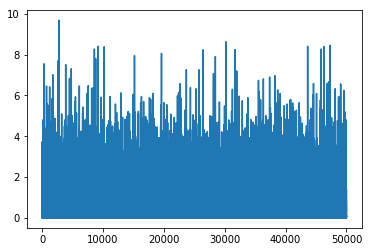

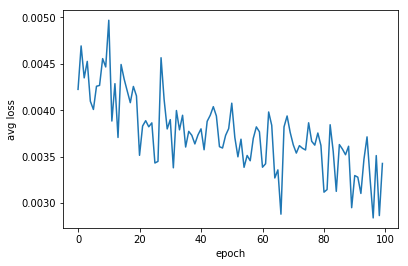

In [28]:
#training function
def train(model, num_epoch, num_iter, rec_interval, disp_interval):
    optimizer = optim.Adam(model.parameters(), lr = 1e-6)
    loss_values = []
    avg_loss_values = []
    rec_step = 0
    print('Starting the training ...')
    for eph in range(num_epoch):
        print('epoch {} starting ...'.format(eph))
        avg_loss = 0
        n_samples = 0
        for i in range(num_iter):
            model.hidden = (model.hidden[0].detach(), model.hidden[1].detach())
            model.zero_grad()
            X,Y = next(ACTd)
            n_samples += len(X)
            X = autograd.Variable(torch.from_numpy(X).float().cuda())
            X = X.view(len(X), 1, -1)
            Y = autograd.Variable(torch.LongTensor(np.array([Y])).cuda())

            y_hat = model(X)
#             print(eph, i, y_hat)
            loss = F.cross_entropy(y_hat, Y)
            avg_loss += loss.data[0]
            
            if i % disp_interval == 0:
                print('epoch: %d iterations: %d loss :%g' % (eph, i, loss.data[0]))
            if rec_step%rec_interval==0:
                loss_values.append(loss.data[0])
            
            loss.backward()     
            optimizer.step()
            rec_step += 1
            
        avg_loss /= n_samples
        avg_loss_values.append(avg_loss)
        #evaluating model accuracy
        acc = evaluate_accuracy(model, test_split)
        print('epoch: {} <====train track===> avg_loss: {}, accuracy: {}% \n'.format(eph, avg_loss, acc))
    return loss_values, avg_loss_values


loss_vals, avg_loss_vals = train(model0, 100, 1000, 2, 100) #ran 4 times with 3e-5,1e-5, 1e-5, 1e-6
plt.figure()
plt.plot(loss_vals)
plt.figure()
plt.plot(avg_loss_vals)
plt.xlabel('epoch')
plt.ylabel('avg loss')

In [30]:
# saving the model
def save_model(model_name, path, model):
    p = path+'/'+model_name
    print('saving at {}'.format(p))
    torch.save(model.state_dict(), p)
    print('saved at {}'.format(p))

In [31]:
save_model('LSTMClassifierX1_c7.pth', './checkpoints', model0)

saving at ./checkpoints/LSTMClassifierX1_c7.pth
saved at ./checkpoints/LSTMClassifierX1_c7.pth


In [33]:
mtest = LSTMClassifier(75, 512, 7, 1, 2, 3).cuda()
mtest.load_state_dict(torch.load('./checkpoints/LSTMClassifierX1_c7.pth'))

In [39]:
mtest.lstm.weight_ih_l0

Parameter containing:
-1.1194e-02  2.1612e-02 -2.4612e-02  ...  -1.8261e-02 -3.4351e-02  2.7542e-02
 2.1613e-02 -2.3839e-02  2.5151e-02  ...  -3.4706e-02 -1.7615e-02  1.7344e-02
-2.4547e-02 -3.1302e-02 -4.1630e-02  ...   4.4822e-03  9.9910e-03 -2.3484e-02
                ...                   ⋱                   ...                
-4.9803e-03  4.4092e-02 -1.6954e-02  ...   2.3005e-02 -4.6648e-02  2.8076e-02
-2.4357e-02  3.0116e-02  2.1181e-02  ...   1.3496e-02 -3.4021e-02 -5.4094e-03
-1.2135e-02  4.3892e-02  3.9074e-02  ...  -5.0744e-03  5.1172e-02 -5.0351e-03
[torch.cuda.FloatTensor of size 2048x75 (GPU 0)]